# Introduction 

#### Assignment:
Project 1 


#### Team: 
Gabriel Castellanos,  Beshkia Kvarnstrom 


## INSTRUCTIONS

For your first project, you are asked to:
1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.

## INTRODUCTION

This datset looks at election records for a number of years aggregated at the precinct, county, and state levels. We can get an idea of how each precinct voted in a given year for a given election-type (general or mid-tem) for a given county or a given state. 


In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import math
import re                     
from itertools import count

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import networkx as nx

# Set the default plot size for matplotlib
plt.rcParams['figure.figsize'] = (25, 15)

# Ignore Python 2 to 3 conversion warnings
import warnings
warnings.filterwarnings("ignore")


#### Import CSV using Pandas

###### Precinct CSV Data

In [2]:
# Read the data from "HOUSE_precinct_general.csv" into a pandas DataFrame
precinct= pd.read_csv("HOUSE_precinct_general.csv")

# Display the number of instances in the DataFrame
precinct.shape

# Display the first 10 rows of the DataFrame
precinct.head(10)

,precinct,office,party_detailed,party_simplified,mode,votes,county_name,county_fips,jurisdiction_name,jurisdiction_fips,...,stage,state,special,writein,state_po,state_fips,state_cen,state_ic,date,readme_check
0,1ST BAPTIST CH IRVINGTON #1,US HOUSE,NaN,NaN,TOTAL,1,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
1,1ST BAPTIST CH IRVINGTON #1,US HOUSE,NaN,NaN,TOTAL,5,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
2,1ST BAPTIST CH IRVINGTON #1,US HOUSE,DEMOCRAT,DEMOCRAT,TOTAL,157,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
3,1ST BAPTIST CH IRVINGTON #1,US HOUSE,REPUBLICAN,REPUBLICAN,TOTAL,605,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
4,1ST BAPTIST CH IRVINGTON #2,US HOUSE,NaN,NaN,TOTAL,0,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
5,1ST BAPTIST CH IRVINGTON #2,US HOUSE,NaN,NaN,TOTAL,6,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
6,1ST BAPTIST CH IRVINGTON #2,US HOUSE,DEMOCRAT,DEMOCRAT,TOTAL,148,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
7,1ST BAPTIST CH IRVINGTON #2,US HOUSE,REPUBLICAN,REPUBLICAN,TOTAL,554,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
8,1ST BAPTIST CH ST ELMO #1,US HOUSE,NaN,NaN,TOTAL,1,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False
9,1ST BAPTIST CH ST ELMO #1,US HOUSE,NaN,NaN,TOTAL,5,MOBILE,1097,MOBILE,1097.0,...,GEN,ALABAMA,False,False,AL,1,63,41,2018-11-06,False


#### Dropping unwanted rows based on needs of Read_me check column:


A lot of variables in the dataset are either redundant or provide extraneous information that is confounding with our analysis. The 'readme_check' variable also allows us to check if a row is trustworthy or not, usually a result of faulty data collection. A TRUE value in this column basically means we need to drop it 

In [3]:
 # Filter rows where 'readme_check' column is False
precinct = precinct[ (precinct['readme_check'] == False) ] # Tackle rows

#### Select the columns that we want

In [4]:
# Keep only the columns 'precinct', 'state', 'votes', 'office', and 'county_name'
precinct = precinct[['precinct', 'state', 'votes', 'office', 'county_name']]


#### Creating a Network Graph

The dabtaset by itself contains 836424 records which is far too many records to fit a netork graph to (at leasy given my computational resources). To accomodate this limitiation, we take a random micro-sample of the original dataset that is more manageable and we can add edges to after the nodes are generated. 

In [5]:
# Keep only the columns 'precinct', 'state', 'votes', 'office', and 'county_name'
precinct=precinct.sample(frac= .008, replace=False, random_state=1)

In [6]:
# Create an empty graph using NetworkX
G = nx.Graph()

# Add nodes to the graph with attributes - 'state', 'office', and 'county'
# Create the business nodes with attributes - name, categories, and neighborhoods.
for index, row in precinct.iterrows():
    # print(row['business_id'])
    G.add_node(row['precinct'],
               state=row['state'],
               office=row['office'],
              county=row['county_name'])




#### Adding Edges to Nodes based on Shared Attributes Between Nodes.

In [7]:
# Add edges between nodes that have at least one common attribute and are not the same node
for node_r, attributes in G.nodes(data=True):
    key_set = set(attributes.keys())
    G.add_edges_from([(node_r, node) for node, attributes in G.nodes(data=True)
                      if key_set.intersection(set(attributes.keys()))
                      and node != node_r])

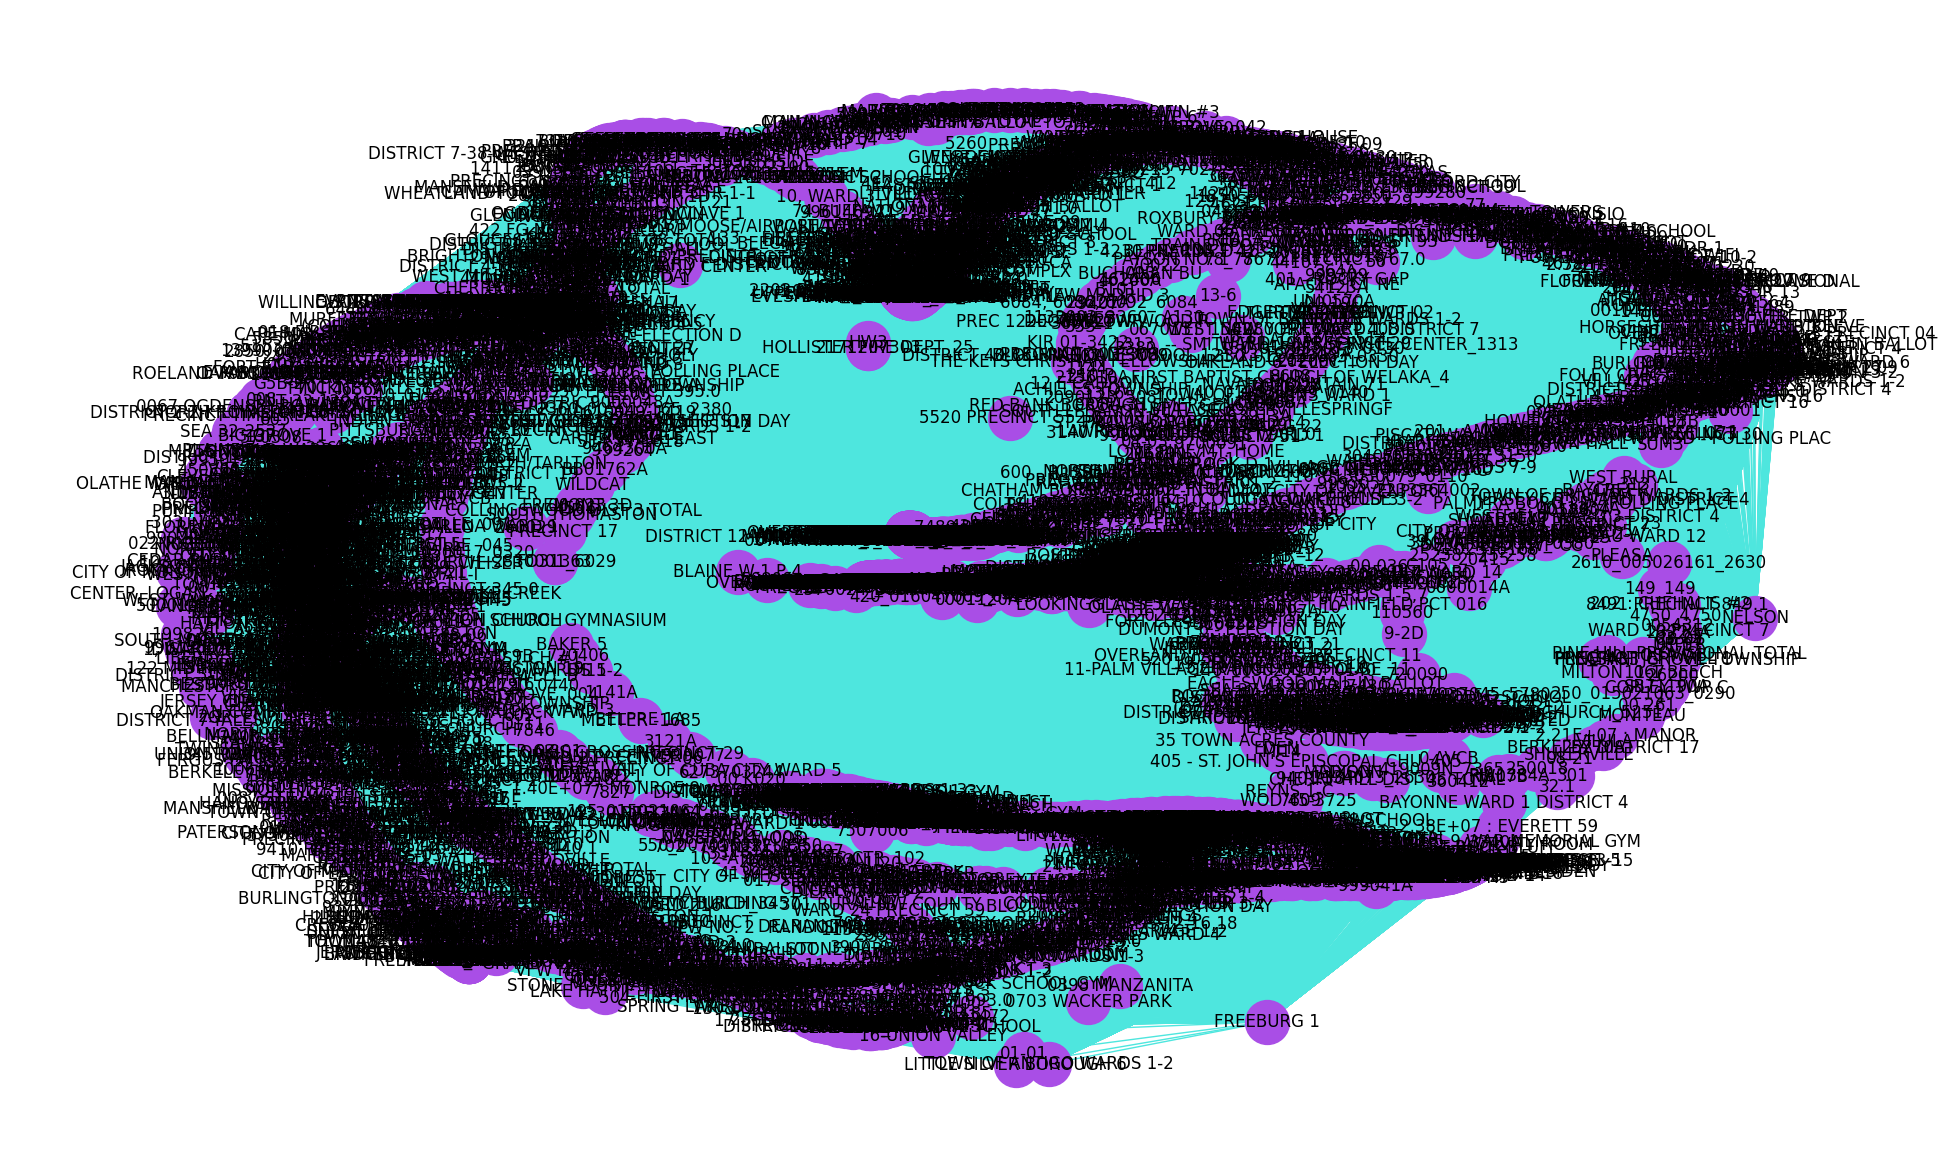

In [8]:
#View the network diagram
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions

fig, ax = plt.subplots()  # Create a figure and an axis object
nx.draw(G, pos, ax=ax, with_labels=True, node_color="#a94ee6", edge_color="#4ee6de", node_size=1000) 
plt.show()


#### Calcuate Node Degree Centrality 

In [9]:
# Calculate the degree centrality for each node in the graph
nx.degree_centrality(G)

{'6084, 6086, 6092_6084': 1.0,
 '1209A': 1.0,
 '55.4': 1.0,
 '13006A': 1.0,
 '450300': 1.0,
 '490121': 1.0,
 '9960351A': 1.0,
 'DEWITT WARD 2': 1.0,
 '02055A': 1.0,
 '6513705A': 1.0,
 '255 : N WHIDBEY 10': 1.0,
 '04-03': 1.0,
 'VIC0449': 1.0,
 'ADDISON  041': 1.0,
 '24-05': 1.0,
 'TOWN OF ANTIGO WARDS 1-2': 1.0,
 'FITCHVILLE TWP': 1.0,
 'COLS 37-B': 1.0,
 '08 ST. JOHN LUTHERAN CHURCH': 1.0,
 '2010296_4314': 1.0,
 'LA36': 1.0,
 'COPLEY TWP C': 1.0,
 'WARD 19 PRECINCT 29': 1.0,
 'CENTREVILLE 3': 1.0,
 'FERGUS FALLS W-2 P-1': 1.0,
 'PRECINCT NEWCOMERSTOWN #3': 1.0,
 '7': 1.0,
 '12': 1.0,
 'P04A': 1.0,
 '5092021106': 1.0,
 '1015-AVCB': 1.0,
 '5512': 1.0,
 '110_013030079_0110': 1.0,
 '3090044_6344': 1.0,
 '401 - FOUR WEST': 1.0,
 '9961399A': 1.0,
 'BARRINGTON DIST 3 TOTAL': 1.0,
 '1470005_3388': 1.0,
 '1141A': 1.0,
 'OGD024': 1.0,
 '04A': 1.0,
 'WAUPONSEE 02': 1.0,
 '5531': 1.0,
 'TUBA CITY SOUTH 95': 1.0,
 'NORTHWEST': 1.0,
 'UNI0676A': 1.0,
 '9-1B': 1.0,
 '200001': 1.0,
 '9963661B': 1.0,


##### Eigenvector Centrality 

In [10]:
# Calculate the eigenvector centrality for each node in the graph
centrality = nx.eigenvector_centrality(G)

# Sort the nodes based on their eigenvector centrality values in descending order
sorted((v, f"{c:0.2f}") for v, c in centrality.items())


[('# AB - CENTRAL ABSENTEE PRECINCT', '0.01'),
 ('## PROVISIONAL', '0.01'),
 ('#12 MISSOURI VALLEY', '0.01'),
 ('(33) GAL 04', '0.01'),
 ('(36) GAL 07', '0.01'),
 ('(75) LIB 13', '0.01'),
 ('(COUNTYWIDE) ABSENTEE/EARLY VOTE', '0.01'),
 ('(D44) CITY OF DAVENPORT', '0.01'),
 ('(D74) CITY OF DAVENPORT', '0.01'),
 ('(D84) CITY OF DAVENPORT', '0.01'),
 ('(WF) WINFIELD TOWNSHIP', '0.01'),
 ('0-AVCB', '0.01'),
 ('00 001', '0.01'),
 ('00 003', '0.01'),
 ('00 004 Z', '0.01'),
 ('00 008', '0.01'),
 ('00 01', '0.01'),
 ('00 011', '0.01'),
 ('00 014 K', '0.01'),
 ('00 023', '0.01'),
 ('00 036', '0.01'),
 ('00 03A', '0.01'),
 ('00 045', '0.01'),
 ('00 05', '0.01'),
 ('00 053', '0.01'),
 ('00 055', '0.01'),
 ('00 057', '0.01'),
 ('00 05S', '0.01'),
 ('00 06', '0.01'),
 ('00 07 B', '0.01'),
 ('00 08', '0.01'),
 ('00 089', '0.01'),
 ('00 091', '0.01'),
 ('00 10', '0.01'),
 ('00 104 Y', '0.01'),
 ('00 107', '0.01'),
 ('00 11', '0.01'),
 ('00 111', '0.01'),
 ('00 113', '0.01'),
 ('00 118', '0.01'),
 ('0

#### 

#### Comaring attributes across nodes

In [11]:
# Create a list of nodes that belong to "ALABAMA" state and have "US HOUSE" office
Alabama = []
for (p, d) in G.nodes(data=True):
    if d['state'] == "ALABAMA"  and  d['office'] == "US HOUSE":
        Alabama.append(p)
        
# Calculate the number of nodes in the 'Alabama' list
len(Alabama)        


73

In [12]:
# Create a list of nodes that belong to "CALIFORNIA" state and have "US HOUSE" office
California = []
for (p, d) in G.nodes(data=True):
    if d['state'] == "CALIFORNIA" and  d['office'] == "US HOUSE":
        California.append(p)
        
# Calculate the number of nodes in the 'California' list
len(California)


729

In [13]:
# Create a list of nodes that have "US HOUSE" office
US_HOUSE = []

for (p, d) in G.nodes(data=True):
  if    d['office'] == "US HOUSE":
        US_HOUSE.append(p)
        
# Calculate the number of nodes in the 'US_HOUSE' list
len(US_HOUSE)



4896